# H3-Indexer Example Notebook

This notebook shares 3 examples:
- Running the H3 Indexer on a single polygon input dataset (Census Population)
- Running the H3 Indexer on a single line input dataset (Railroad Network)
- Running the H3 Indexer on 2 input datasets and then calculating a combined metric from the output

### Data Sources
- [Census County Shapefiles w/ Geometry](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=Counties+%28and+equivalent%29)
- [Census County Population](https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html)
- [North American Rail Network Lines](https://geodata.bts.gov/datasets/usdot::north-american-rail-network-lines/about)

In [102]:
import geopandas as gpd
import pandas as pd
import pyarrow.dataset as ds

### Example 1: Census Data

In [103]:
gdf = gpd.read_file("data/tl_2024_us_county/tl_2024_us_county.shp")
pop_df = pd.read_csv("data/co-est2024-alldata.csv", encoding = "ISO-8859-1")

In [104]:
pop_df['STATE'] = pop_df['STATE'].astype(str).str.zfill(2)
gdf_pop = gdf.merge(pop_df[['STATE','CTYNAME','POPESTIMATE2024']], how='left', left_on=['STATEFP', 'NAMELSAD'], right_on=['STATE','CTYNAME'])
gdf_pop = gdf_pop.drop_duplicates()

In [105]:
print(len(gdf_pop))
print(len(gdf_pop['GEOID'].unique()))

3235
3235


In [106]:
gdf_pop.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,STATE,CTYNAME,POPESTIMATE2024
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,None,A,1477563042,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55525 41.82892, -96.55524 41.827...",31,Cuming County,8952.0
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,None,A,680980773,61564428,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.2645, -123.72756 46.26...",53,Wahkiakum County,4800.0


<Axes: >

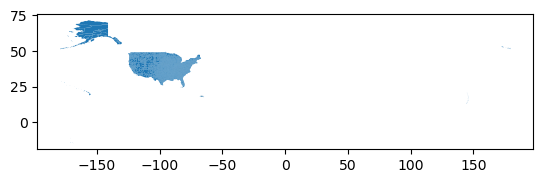

In [107]:
gdf_pop.plot()

Clip to CONUS

In [108]:
from shapely.wkt import loads

# CONUS boundary simplified WKT
conus_wkt = """POLYGON((-124.848974 24.396308,-66.885444 24.396308,
                        -66.885444 49.384358,-124.848974 49.384358,
                        -124.848974 24.396308))"""
conus_geometry = loads(conus_wkt)
gdf_conus = gdf_pop[gdf_pop.geometry.intersects(conus_geometry)]

<Axes: >

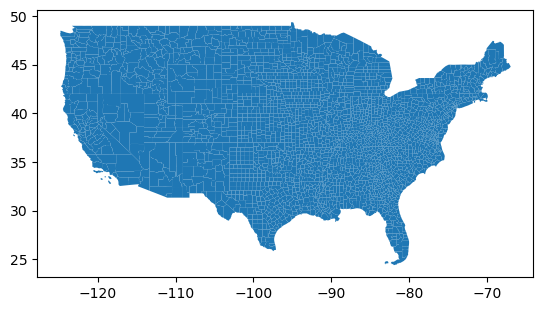

In [109]:
gdf_conus.plot()

Save shapefile and upload to S3

In [110]:
gdf_conus.to_file("data/tl_2024_us_county/tl_2024_us_county_pop_conus.shp")

/var/folders/7r/sqrdbgxx6n7_gwgbkd8fxqrc0000gq/T/ipykernel_95903/647995259.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_conus.to_file("data/tl_2024_us_county/tl_2024_us_county_pop_conus.shp")
/Users/madiejf/miniconda3/envs/geoenv/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'POPESTIMATE2024' to 'POPESTIMAT'
  ogr_write(


In [111]:
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm
import numpy as np

In [112]:
def plot_function(gdf, column, title):
    gdf_web = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # calculate custom breaks
    min_val = gdf_web[column].min()
    max_val = gdf_web[column].max()
    breaks = [min_val,
              np.percentile(gdf_web[column], 25),
              np.percentile(gdf_web[column], 40),
              np.percentile(gdf_web[column], 75),
              np.percentile(gdf_web[column], 95),
              np.percentile(gdf_web[column], 97.5),
              max_val]
    
    # plot choropleth
    gdf_web.plot(column=column,
                 ax=ax,
                 legend=True,
                 legend_kwds={'title': title, 'loc': 'lower right'},
                 cmap='YlOrRd',
                 scheme='user_defined',
                 classification_kwds={'bins': breaks})
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    plt.title(title)

    return

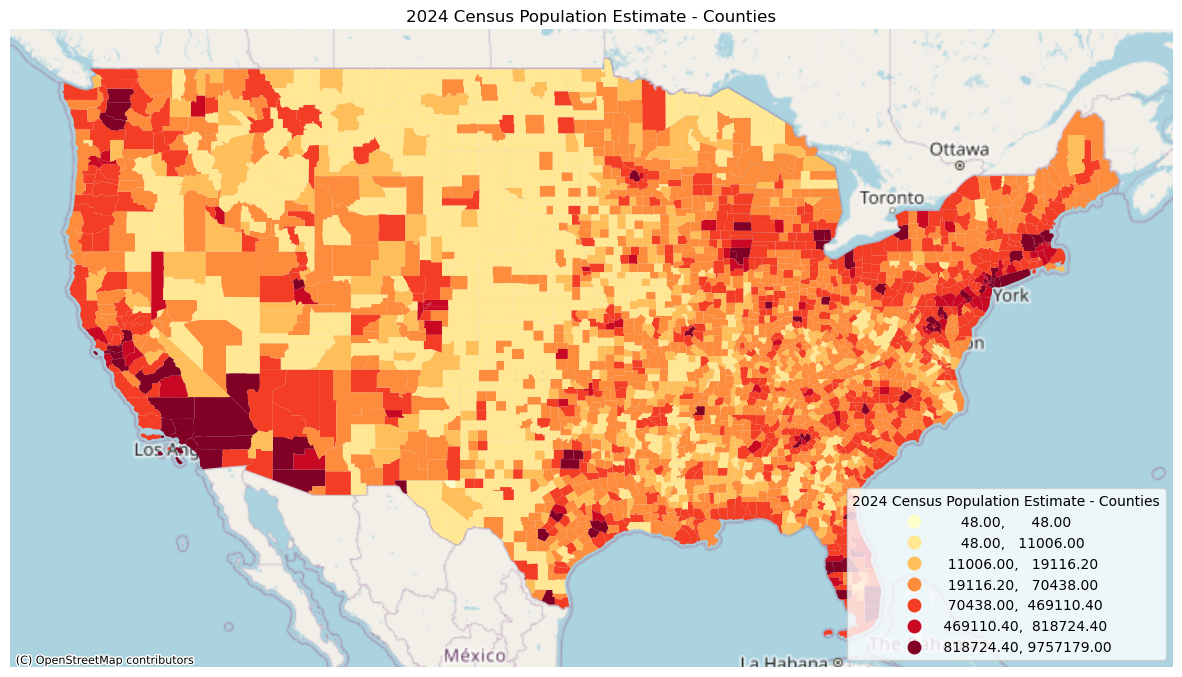

In [113]:
plot_function(gdf_conus, 'POPESTIMATE2024', '2024 Census Population Estimate - Counties')

### Now, plot the results after running the H3-Indexer on the data

Example yaml config for the H3-Indexer:
```
name: "county_pop_example"
version: "1.0.0"
h3_resolution: 4
output_s3_path: 'wws-air-quality/h3-indexer-outputs'
inputs:
  county_pop:  
    type: "vector"
    s3_path: "wws-air-quality/census/tl_2024_us_county/tl_2024_us_county_pop_conus.shp"
    unique_id: "GEOID"
    geometry_type: "POLYGON"
    geometry_column_name: "geometry"
    method: "PCT_AREA"
    input_columns:
      - "POPESTIMAT"
```

(Data was moved from the output S3 path into my local data directory)

In [114]:
path = 'data/tl_2024_us_county/resolver_output'
dataset = ds.dataset(path, format="parquet")
h3_df = dataset.to_table().to_pandas()

In [115]:
import h3
from shapely.geometry import Polygon

def h3_to_geom(h3_index):
    coords = h3.cell_to_boundary(h3_index)
    boundary = [[coord[1], coord[0]] for coord in coords]
    boundary.append(boundary[0])  # Close the polygon
    polygon = Polygon(boundary)
    return polygon.wkt

In [116]:
h3_df['wkt_column'] = h3_df['h3_index'].apply(h3_to_geom)
h3_df['geometry'] = gpd.GeoSeries.from_wkt(h3_df['wkt_column'])
gdf_h3 = gpd.GeoDataFrame(h3_df, geometry='geometry').drop('wkt_column', axis=1)
gdf_h3 = gdf_h3.set_crs(epsg=4326)
gdf_h3.head(2)

,h3_index,h3_area_km2,sum_POPESTIMAT,geometry
0,8412c87ffffffff,1656.520601,48.563249,"POLYGON ((-113.74631 49.40961, -113.97755 49.2..."
1,8412c95ffffffff,1669.498773,1567.855674,"POLYGON ((-112.72637 49.20722, -112.96215 49.0..."


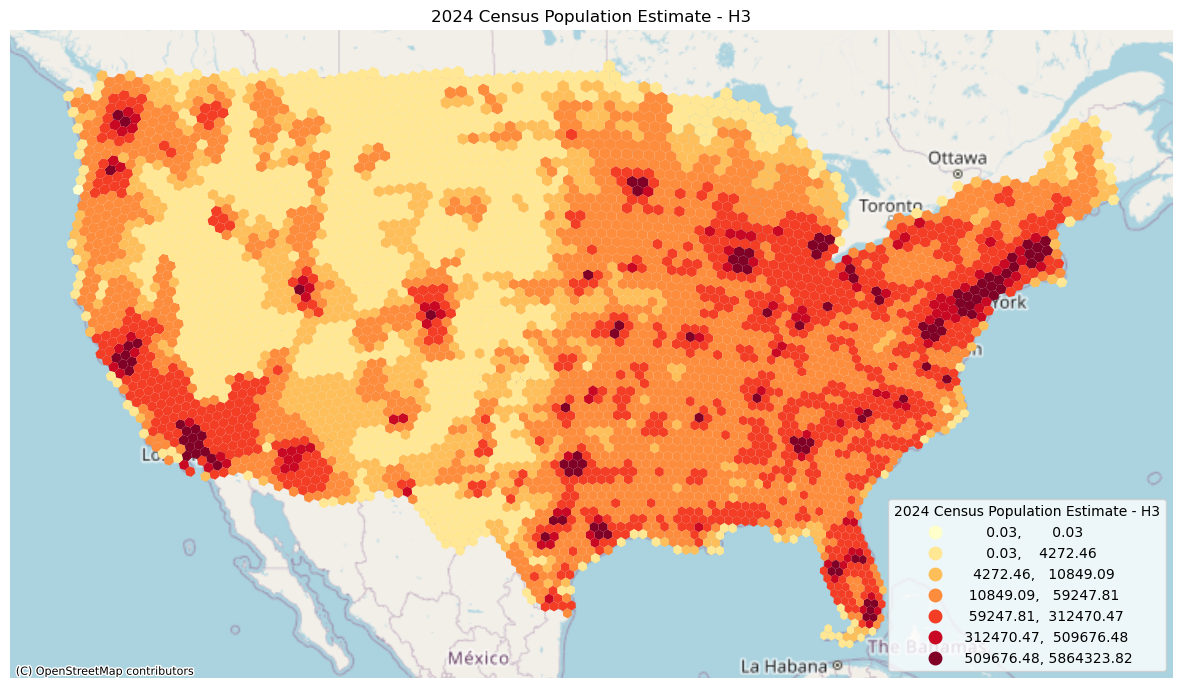

In [123]:
plot_function(gdf_h3, 'sum_POPESTIMAT', '2024 Census Population Estimate - H3')

### Example 2: Railroad Network Data

In [69]:
t_gdf = gpd.read_file("data/NTAD_North_American_Rail_Network_Lines_-5224344650325060440.gpkg")
t_gdf_conus = t_gdf[t_gdf.geometry.intersects(conus_geometry)]

In [70]:
t_gdf_conus.head(2)

,FRAARCID,FRFRANODE,TOFRANODE,STFIPS,CNTYFIPS,STCNTYFIPS,STATEAB,COUNTRY,FRADISTRCT,RROWNER1,...,BRANCH,YARDNAME,PASSNGR,STRACNET,TRACKS,NET,MILES,KM,TIMEZONE,geometry
0,300000,348741,348746,38,015,38015,ND,US,8,DMVW,...,XLINE,None,None,None,1.0,M,0.178101,0.286626,C,"MULTILINESTRING ((-100.74521 46.80285, -100.74..."
1,300001,338567,338686,30,087,30087,MT,US,8,BNSF,...,None,None,None,None,0.0,O,0.886585,1.426824,M,"MULTILINESTRING ((-106.65759 45.86405, -106.65..."


In [73]:
print("Geom Type Stats:", t_gdf_conus.geometry.type.value_counts())

Geom Type Stats: MultiLineString    269066
Name: count, dtype: int64


We must first convert all of the MultiLineString geometries to LineString geometries.

In [74]:
from shapely.geometry import LineString, MultiLineString

def convert_multiline_to_line(geometry):
    # If it's already a LineString, return as is
    if isinstance(geometry, LineString):
        return geometry
    
    # If it's a MultiLineString with only one line, convert to LineString
    if isinstance(geometry, MultiLineString) and len(geometry.geoms) == 1:
        return LineString(geometry.geoms[0])
    
    # Otherwise return the original MultiLineString
    return geometry

t_gdf_conus['geometry'] = t_gdf_conus['geometry'].apply(convert_multiline_to_line)

/Users/madiejf/miniconda3/envs/geoenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [75]:
print("Geom Type Stats:", t_gdf_conus.geometry.type.value_counts())

Geom Type Stats: LineString    269066
Name: count, dtype: int64


Now we add a dummy attribute called 'dummy_train_attribute' which is a function of the length of the line in kilometers. We'll use this attribute later in the resolver step.

In [76]:
t_gdf_conus['dummy_train_attribute'] = t_gdf_conus['KM']*1000

/Users/madiejf/miniconda3/envs/geoenv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


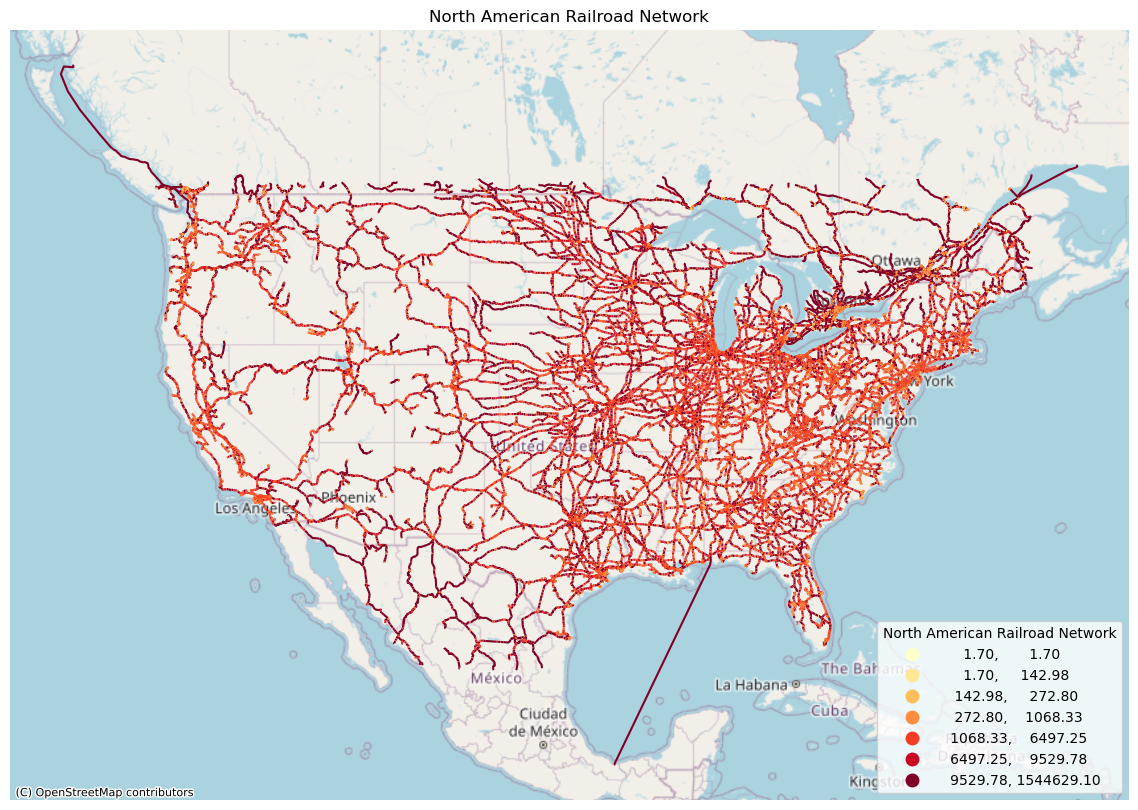

In [78]:
plot_function(t_gdf_conus, 'dummy_train_attribute', 'North American Railroad Network')

In [82]:
t_gdf_conus.to_parquet('data/North_American_Rail_Network.parquet')

### Now, plot the results after running the H3 Indexer

Example yaml config for the H3 Indexer:
```
name: "railroad_network"
version: "1.0.0"
h3_resolution: 4
output_s3_path: 'wws-air-quality/h3-indexer-outputs'
inputs:
  railroads:  
    type: "vector"
    s3_path: "wws-air-quality/testing/railroad_network/North_American_Rail_Network.parquet"
    unique_id: "FRAARCID"
    geometry_type: "LINE"
    geometry_column_name: "geometry"
    method: "PCT_LENGTH"
    input_columns:
      - "dummy_train_attribute"
```

(Data was moved from the output S3 path into my local data directory)

In [89]:
path = 'data/railroad_resolved'
dataset = ds.dataset(path, format="parquet")
rr_h3_df = dataset.to_table().to_pandas()

In [90]:
rr_h3_df['wkt_column'] = rr_h3_df['h3_index'].apply(h3_to_geom)
rr_h3_df['geometry'] = gpd.GeoSeries.from_wkt(rr_h3_df['wkt_column'])
gdf_rr_h3 = gpd.GeoDataFrame(rr_h3_df, geometry='geometry').drop('wkt_column', axis=1)
gdf_rr_h3 = gdf_rr_h3.set_crs(epsg=4326)
gdf_rr_h3.head(2)

,h3_index,h3_area_km2,sum_dummy_train_attribute,geometry
0,840e491ffffffff,1999.657751,27745.251393,"POLYGON ((-67.7627 49.5986, -68.14734 49.56361..."
1,840e493ffffffff,1989.928048,111973.777499,"POLYGON ((-67.68094 49.17487, -68.06172 49.140..."


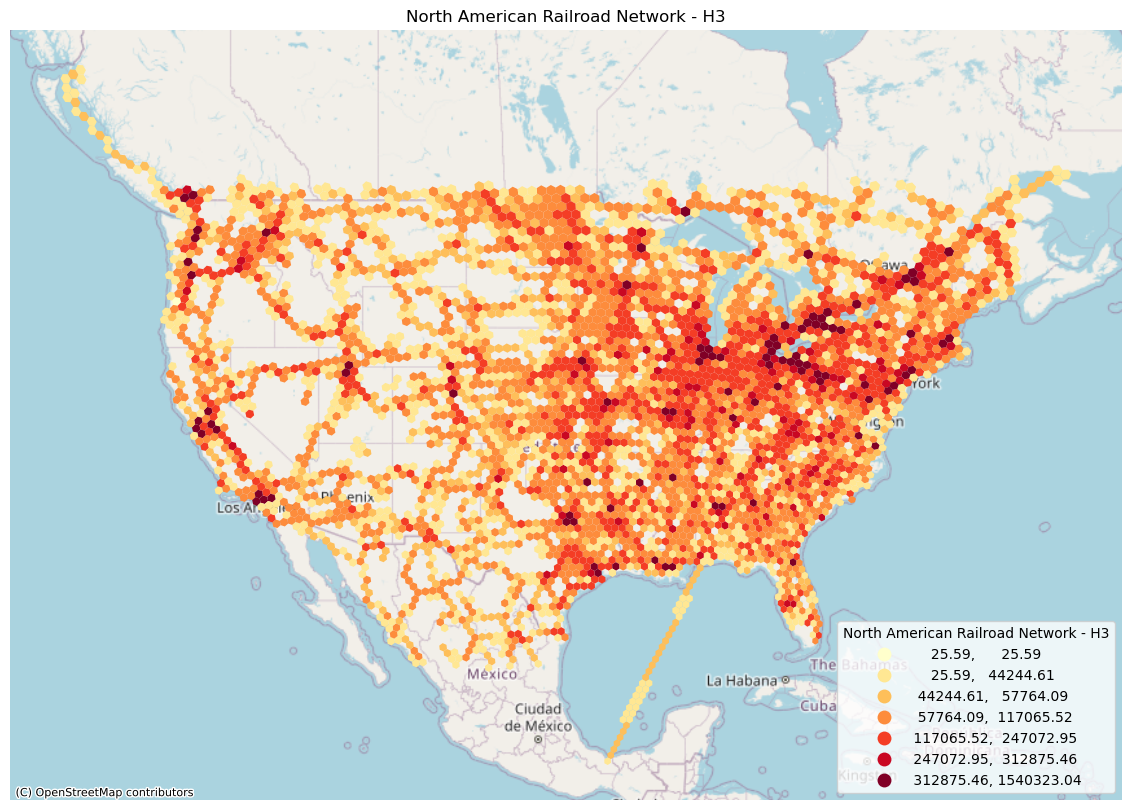

In [91]:
plot_function(gdf_rr_h3, 'sum_dummy_train_attribute', 'North American Railroad Network - H3')

### Example 3: Multiple Inputs
At this point, we've run the H3 Indexer separately for both our county population data, which is made up of Polygons, and our railroad network data, which is made up of Lines. The power of the H3 Indexer, is that these inputs don't need to be separated out in to different configs. They can be run together in the same job, to produce a single table with all of the H3 grids and resolved attributes of both inputs.

Now, instead of running them one by one, let's include them in the same config and have the H3 Indexer produce a single resolved output.

Example yaml config for the H3 Indexer:

```
name: "railroad_population_example"
version: "1.0.0"
h3_resolution: 4
output_s3_path: 'wws-air-quality/h3-indexer-outputs'
inputs:
  railroads:  
    type: "vector"
    s3_path: "wws-air-quality/testing/railroad_network/North_American_Rail_Network.parquet"
    unique_id: "FRAARCID"
    geometry_type: "LINE"
    geometry_column_name: "geometry"
    method: "PCT_LENGTH"
    input_columns:
      - "dummy_train_attribute"
  county_pop:  
    type: "vector"
    s3_path: "wws-air-quality/census/tl_2024_us_county/tl_2024_us_county_pop_conus.shp"
    unique_id: "GEOID"
    geometry_type: "POLYGON"
    geometry_column_name: "geometry"
    method: "PCT_AREA"
    input_columns:
      - "POPESTIMAT"
```

(Data was moved from the output S3 path into my local data directory)

In [ ]:
path = 'data/railroad_pop_combined'
dataset = ds.dataset(path, format="parquet")
combo_h3_df = dataset.to_table().to_pandas()

In [ ]:
combo_h3_df['wkt_column'] = combo_h3_df['h3_index'].apply(h3_to_geom)
combo_h3_df['geometry'] = gpd.GeoSeries.from_wkt(combo_h3_df['wkt_column'])
gdf_combo_h3 = gpd.GeoDataFrame(combo_h3_df, geometry='geometry').drop('wkt_column', axis=1)
gdf_combo_h3 = gdf_combo_h3.set_crs(epsg=4326)

In [94]:
gdf_combo_h3.head()

,h3_index,h3_area_km2,sum_dummy_train_attribute,geometry,sum_POPESTIMAT
0,840e491ffffffff,1999.657751,27745.251393,"POLYGON ((-67.7627 49.5986, -68.14734 49.56361...",NaN
1,840e493ffffffff,1989.928048,111973.777499,"POLYGON ((-67.68094 49.17487, -68.06172 49.140...",NaN
2,840e497ffffffff,1996.753416,6685.897330,"POLYGON ((-68.29551 49.33378, -68.67762 49.296...",NaN
3,840e49bffffffff,1992.641780,79179.094471,"POLYGON ((-67.14693 49.43649, -67.53013 49.403...",NaN
4,840e4d3ffffffff,2004.434447,16874.150271,"POLYGON ((-66.67837 50.12138, -67.06795 50.090...",NaN


Now, lets's add a new metric that is a function of both the population and the presence of trains.

In [130]:
combined_df['new_metric'] = combined_df['sum_POPESTIMAT'] + combined_df['sum_dummy_train_attribute']

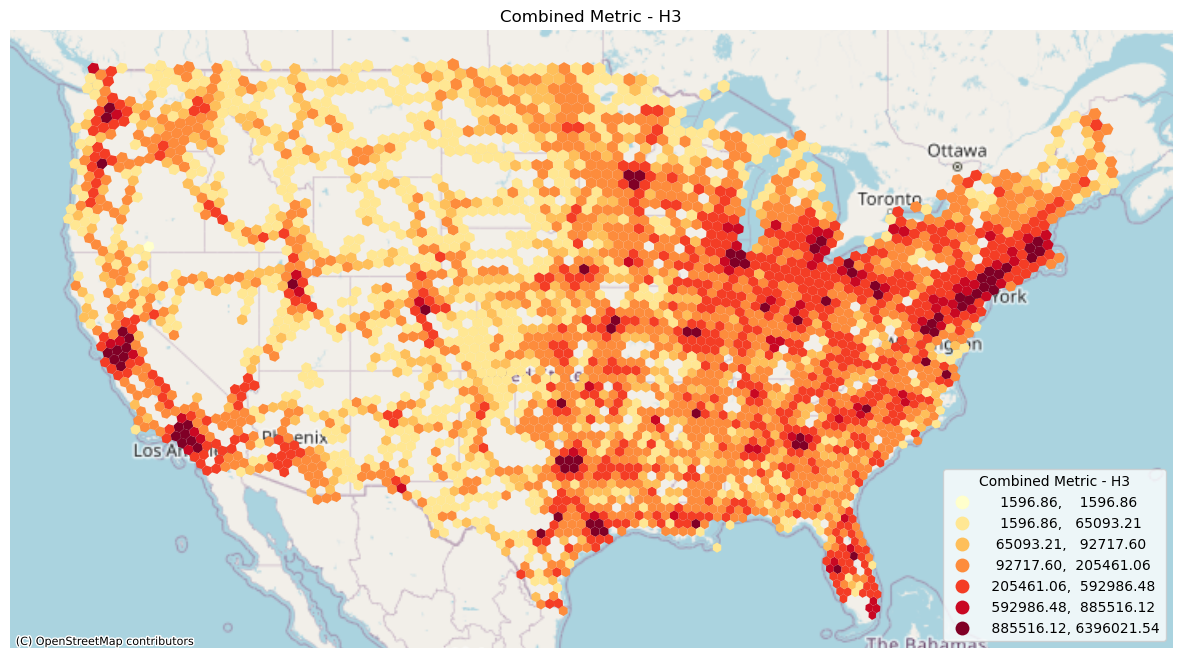

In [131]:
plot_function(combined_df[combined_df['new_metric'].notnull()], 'new_metric', 'Combined Metric - H3')